Minimum value of 'ACC': 0.0
Lambda for Box-Cox transformation: 4.015924094155453


<ipython-input-61-455490658cea>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['ACC'] = df_target['ACC'] - min_val + 1e-6  # Shift by (-min_val + a small epsilon)
<ipython-input-61-455490658cea>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['ACC'] = data_bc


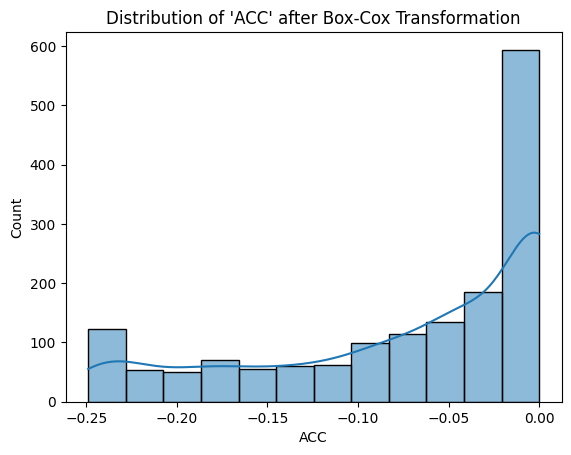

FreqContext   AoA  nMeaning  zImageability  zConcreteness  Phonogram  \
0           12.14  11.0         3       0.404177      -0.103212          1   
1           10.04  10.0         1       0.176291       0.319844          1   
2            6.97  11.0         2       0.919010       1.180032          1   
3           96.22   6.5         6       0.527291       0.691302          0   
4           54.78   7.0         2      -0.039290      -0.234004          0   
...           ...   ...       ...            ...            ...        ...   
1595        54.43   8.0         4      -0.326855      -0.556125          1   
1596        15.20   8.0         4       0.116090       0.412641          1   
1597        66.75   8.0         3       0.846971       1.447112          1   
1598        31.51  10.0         3       0.596776       0.297512          1   
1599        98.40   7.5         6      -0.933269      -0.817521          1   

      SRO  zRegularity  logHomoDen  nStroke  nRadical  Comp_LR  Comp_TD  \
0       1    -1.129938    0.845098        9         3        0        1   
1       0    -0.791032    0.602060       17         5        0        1   
2       0     1.628670    0.954243        9         2        0        1   
3       0    -0.678238    0.301030        5         1        0        1   
4       0     0.808703    0.698970        6         1        0        1   
...   ...          ...         ...      ...       ...      ...      ...   
1595    0    -0.537260    0.698970        8         2        1        1   
1596    0     0.119311    0.698970       10         3        1        1   
1597    0    -0.765818    0.301030       16         6        1        1   
1598    0     0.041332    0.477121       15         5        1        1   
1599    0    -0.125166    0.602060        7         2        1        1   

      zwFamiliarity       ACC  
0          0.246514 -0.036287  
1          0.124141 -0.158247  
2          0.236796 -0.042432  
3          0.624572  0.000001  
4          0.652549  0.000001  
...             ...       ...  
1595       0.805597 -0.154470  
1596       0.206908 -0.037651  
1597       0.281361 -0.055288  
1598       0.260725 -0.066203  
1599       0.767954  0.000001  

[1600 rows x 15 columns]

In [ ]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import shap
import itertools
import seaborn as sns
from scipy.stats import boxcox
import xgboost
import sklearn





from scipy import stats
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from scipy import stats
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from PIL import Image, ImageDraw, ImageFont
from scipy.stats import boxcox

# Read Excel data
file_path = 'Database.xlsx'
sheet_name = 'Data'
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Select specific features
pridictive_features = [
    'FreqContext', 'AoA', 'nMeaning', 'zImageability', 'zConcreteness',
    'Phonogram', 'SRO', 'zRegularity', 'logHomoDen', 'nStroke', 'nRadical',
    'Comp_LR', 'Comp_TD', 'zwFamiliarity'
]


# Select predictive features (DataFrame)
pridictive_features = df[pridictive_features]

# Select the target column (ACC)
target_columns = ['ACC']
df_target = df[target_columns]

# Select character features (later use)
features_Character = ['Character']
df_Character = df[features_Character]

# Check the minimum value of 'ACC'
min_val = df_target['ACC'].min()
print("Minimum value of 'ACC':", min_val)

#  If the minimum value is <= 0, shift the data to make all values strictly positive
if min_val <= 0:
    df_target['ACC'] = df_target['ACC'] - min_val + 1e-6  # Shift by (-min_val + a small epsilon)

#  Apply Box-Cox transformation using scipy.stats.boxcox
data_bc, lam = stats.boxcox(df_target['ACC'])

#  Store the transformed data back into the DataFrame
df_target['ACC'] = data_bc
print("Lambda for Box-Cox transformation:", lam)

#  Combine the processed target with the predictive features
df_processed = pd.concat([pridictive_features, df_target['ACC']], axis=1)

#  Plot the distribution of the transformed 'ACC'
sns.histplot(df_processed['ACC'], kde=True)
plt.title("Distribution of 'ACC' after Box-Cox Transformation")
plt.show()

#  Print the head of the final processed DataFrame
df_processed

In [ ]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FreqContext    1600 non-null   float64
 1   AoA            1600 non-null   float64
 2   nMeaning       1600 non-null   int64  
 3   zImageability  1600 non-null   float64
 4   zConcreteness  1600 non-null   float64
 5   Phonogram      1600 non-null   int64  
 6   SRO            1600 non-null   int64  
 7   zRegularity    1600 non-null   float64
 8   logHomoDen     1600 non-null   float64
 9   nStroke        1600 non-null   int64  
 10  nRadical       1600 non-null   int64  
 11  Comp_LR        1600 non-null   int64  
 12  Comp_TD        1600 non-null   int64  
 13  zwFamiliarity  1600 non-null   float64
 14  ACC            1600 non-null   float64
dtypes: float64(8), int64(7)
memory usage: 187.6 KB


In [ ]:
df_processed.nunique()

FreqContext      1293
AoA                13
nMeaning           15
zImageability    1600
zConcreteness    1600
Phonogram           2
SRO                 2
zRegularity      1600
logHomoDen         33
nStroke            18
nRadical            7
Comp_LR             2
Comp_TD             2
zwFamiliarity    1475
ACC               237
dtype: int64

In [ ]:
df_processed.isnull().sum()

FreqContext      0
AoA              0
nMeaning         0
zImageability    0
zConcreteness    0
Phonogram        0
SRO              0
zRegularity      0
logHomoDen       0
nStroke          0
nRadical         0
Comp_LR          0
Comp_TD          0
zwFamiliarity    0
ACC              0
dtype: int64

In [ ]:
(df_processed.isnull().sum()/(len(df_processed)))*100

FreqContext      0.0
AoA              0.0
nMeaning         0.0
zImageability    0.0
zConcreteness    0.0
Phonogram        0.0
SRO              0.0
zRegularity      0.0
logHomoDen       0.0
nStroke          0.0
nRadical         0.0
Comp_LR          0.0
Comp_TD          0.0
zwFamiliarity    0.0
ACC              0.0
dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler

df_processed_normalized = pridictive_features.copy()
scaler = MinMaxScaler()
arr_scaled = scaler.fit_transform(df_processed_normalized)

df_processed_normalized = pd.DataFrame(
    arr_scaled,
    columns=pridictive_features.columns,
    index=pridictive_features.index
)



df_processed = pd.concat([df_processed_normalized, df_target], axis=1)


print(df_processed)

      FreqContext       AoA  nMeaning  zImageability  zConcreteness  \
0        0.119743  0.750000  0.133333       0.706227       0.488514   
1        0.098665  0.583333  0.000000       0.636563       0.618704   
2        0.067851  0.750000  0.066667       0.863608       0.883415   
3        0.963666  0.000000  0.333333       0.743862       0.733015   
4        0.547727  0.083333  0.066667       0.570661       0.448264   
...           ...       ...       ...            ...            ...   
1595     0.544214  0.250000  0.200000       0.482755       0.349136   
1596     0.150457  0.250000  0.200000       0.618160       0.647261   
1597     0.667871  0.250000  0.133333       0.841586       0.965605   
1598     0.314162  0.583333  0.133333       0.765103       0.611831   
1599     0.985547  0.166667  0.333333       0.297377       0.268695   

      Phonogram  SRO  zRegularity  logHomoDen   nStroke  nRadical  Comp_LR  \
0           1.0  1.0     0.057296    0.492480  0.222222  0.333333    

In [ ]:
df_processed.describe(include='all').T

count      mean       std       min       25%       50%  \
FreqContext    1600.0  0.312644  0.292219  0.000000  0.069532  0.200241   
AoA            1600.0  0.429167  0.287394  0.000000  0.166667  0.333333   
nMeaning       1600.0  0.139708  0.136469  0.000000  0.066667  0.133333   
zImageability  1600.0  0.582171  0.181229  0.000000  0.451015  0.591978   
zConcreteness  1600.0  0.520706  0.211315  0.000000  0.356193  0.498142   
Phonogram      1600.0  0.753125  0.431328  0.000000  1.000000  1.000000   
SRO            1600.0  0.183750  0.387401  0.000000  0.000000  0.000000   
zRegularity    1600.0  0.430650  0.281158  0.000000  0.193031  0.326375   
logHomoDen     1600.0  0.510952  0.202433  0.000000  0.407324  0.526275   
nStroke        1600.0  0.269028  0.170679  0.000000  0.166667  0.222222   
nRadical       1600.0  0.332500  0.171240  0.000000  0.166667  0.333333   
Comp_LR        1600.0  0.589375  0.492101  0.000000  0.000000  1.000000   
Comp_TD        1600.0  0.731875  0.443122  0.000000  0.000000  1.000000   
zwFamiliarity  1600.0  0.656654  0.142185  0.000000  0.588765  0.681153   
ACC            1600.0 -0.073823  0.080733 -0.249009 -0.129271 -0.042432   

                    75%       max  
FreqContext    0.511317  1.000000  
AoA            0.666667  1.000000  
nMeaning       0.200000  1.000000  
zImageability  0.720074  1.000000  
zConcreteness  0.677799  1.000000  
Phonogram      1.000000  1.000000  
SRO            0.000000  1.000000  
zRegularity    0.673212  1.000000  
logHomoDen     0.649150  1.000000  
nStroke        0.388889  1.000000  
nRadical       0.500000  1.000000  
Comp_LR        1.000000  1.000000  
Comp_TD        1.000000  1.000000  
zwFamiliarity  0.752214  1.000000  
ACC            0.000001  0.000001


=== Univariate Analysis with Histogram & Skew ===
Feature 'FreqContext' skew = 0.90


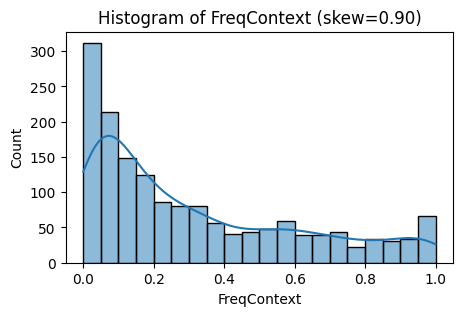

Feature 'AoA' skew = 0.55


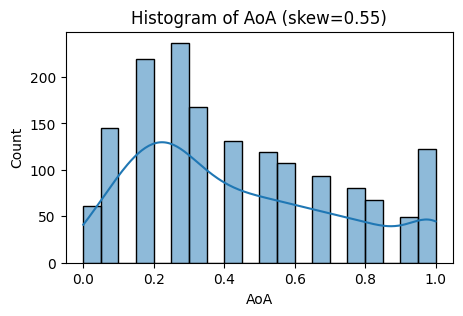

Feature 'nMeaning' skew = 1.56


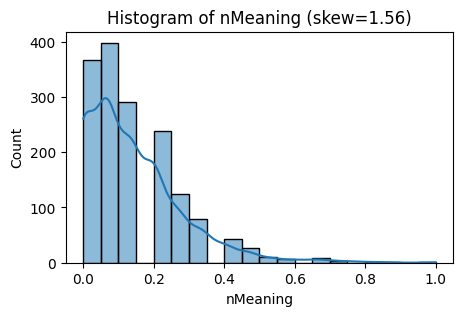

Feature 'zImageability' skew = -0.18


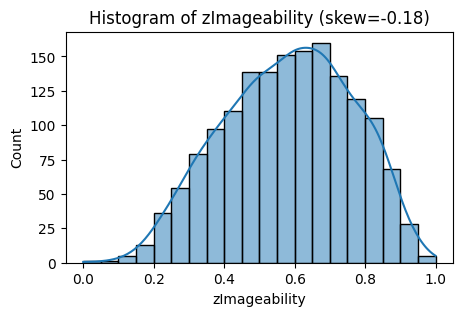

Feature 'zConcreteness' skew = 0.15


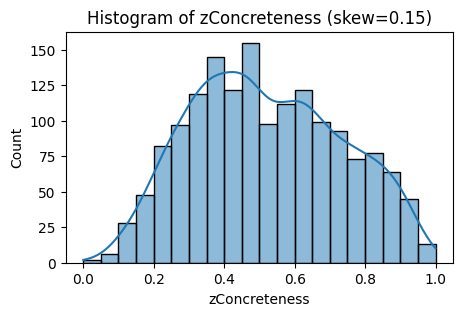

Feature 'Phonogram' skew = -1.18


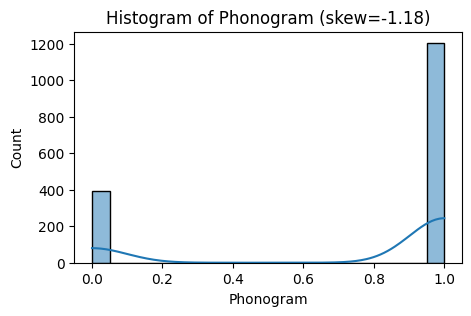

Feature 'SRO' skew = 1.63


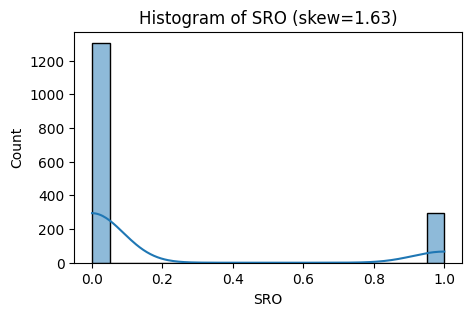

Feature 'zRegularity' skew = 0.62


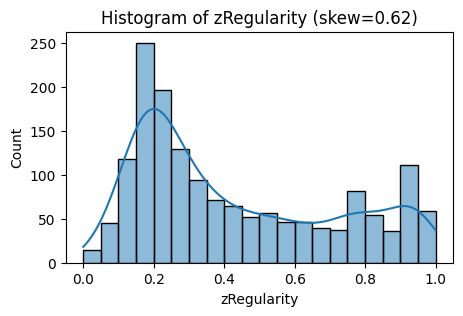

Feature 'logHomoDen' skew = -0.44


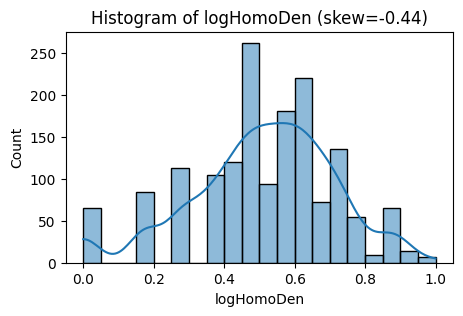

Feature 'nStroke' skew = 0.72


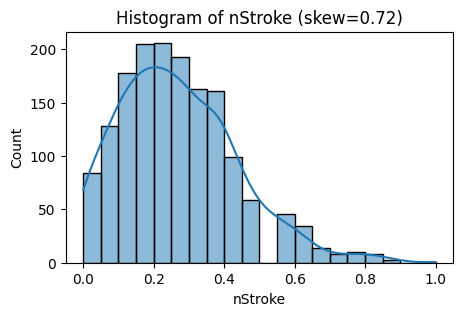

Feature 'nRadical' skew = 0.59


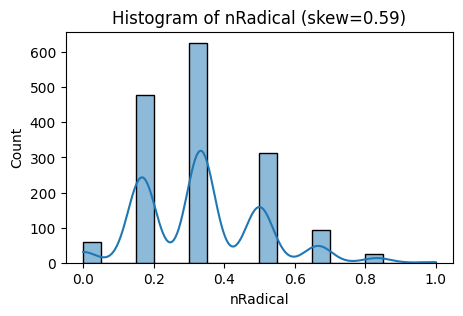

Feature 'Comp_LR' skew = -0.36


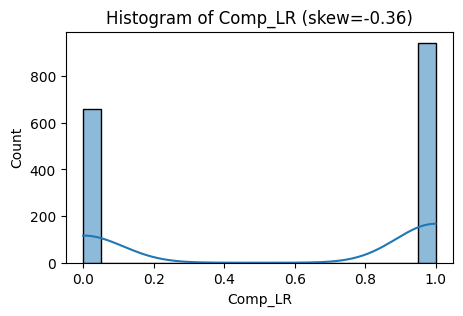

Feature 'Comp_TD' skew = -1.05


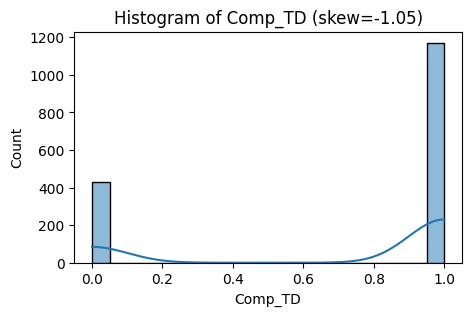

Feature 'zwFamiliarity' skew = -1.00


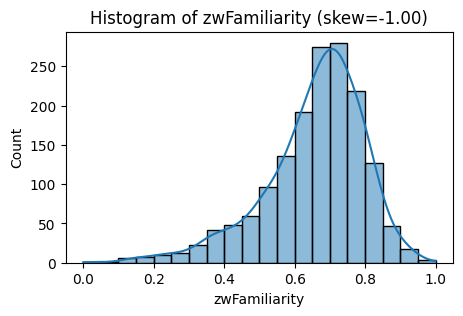

Feature 'ACC' skew = -0.85


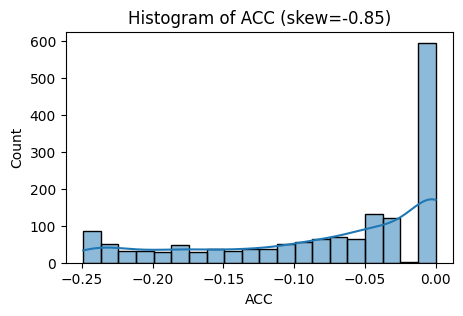

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()


print("\n=== Univariate Analysis with Histogram & Skew ===")
for col in numeric_cols:
    col_skew = df_processed[col].skew()
    print(f"Feature '{col}' skew = {col_skew:.2f}")

    plt.figure(figsize=(5, 3))
    sns.histplot(df_processed[col], kde=True, bins=20)
    plt.title(f"Histogram of {col} (skew={col_skew:.2f})")
    plt.show()

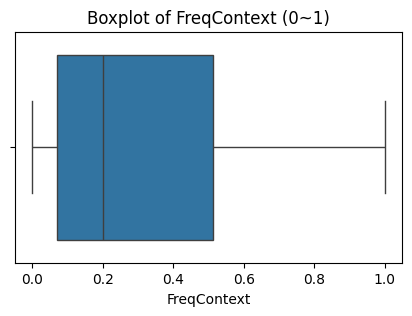

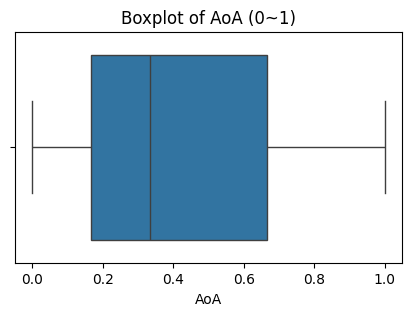

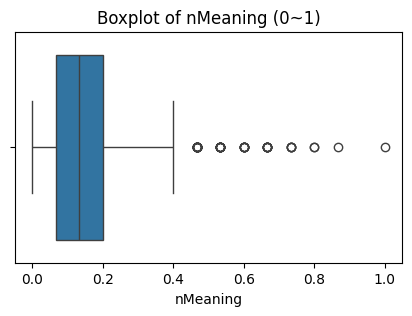

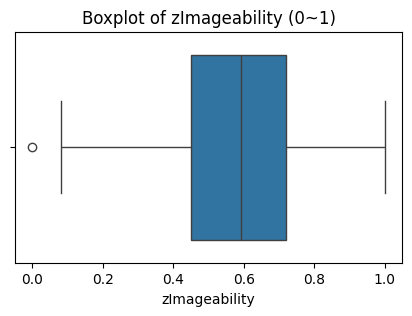

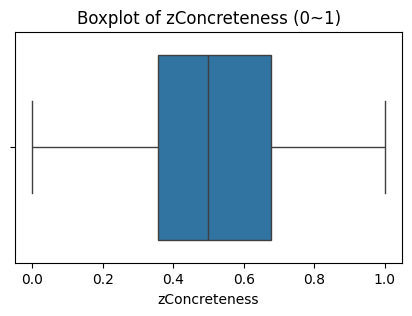

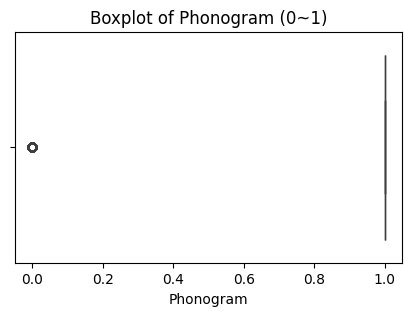

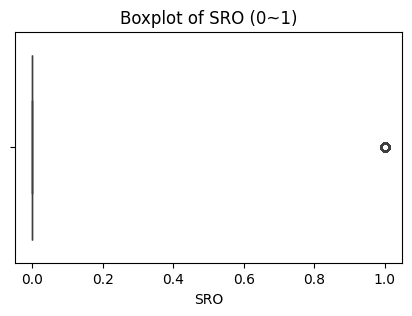

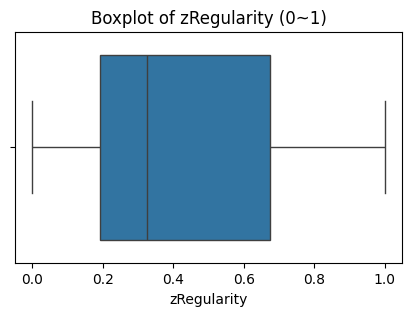

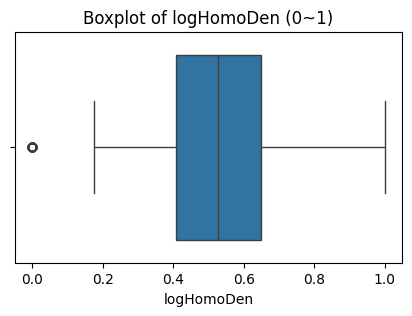

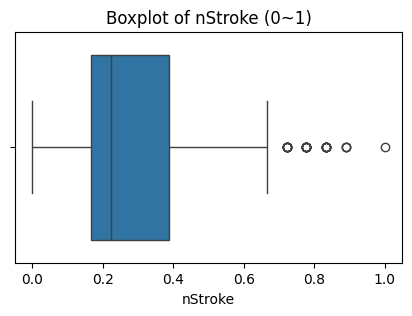

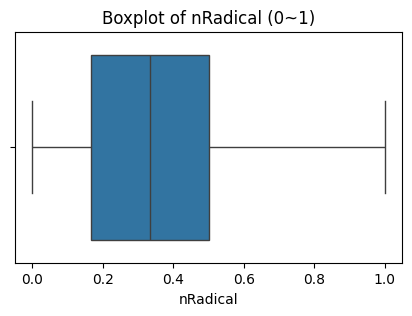

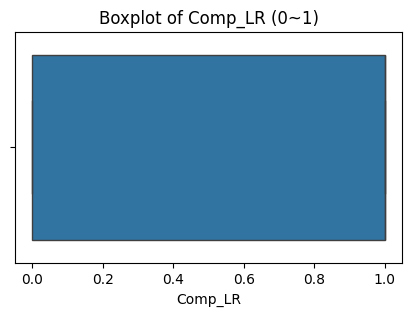

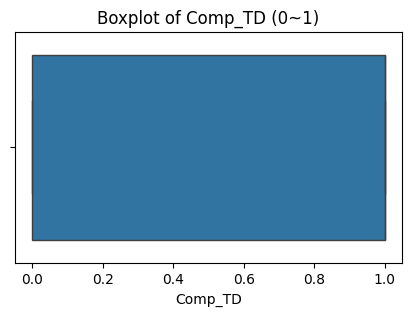

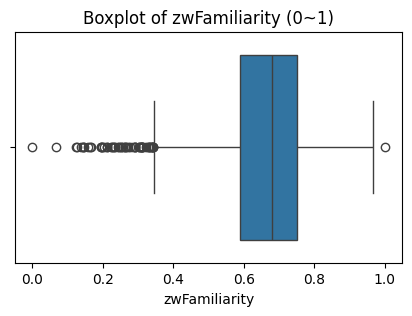

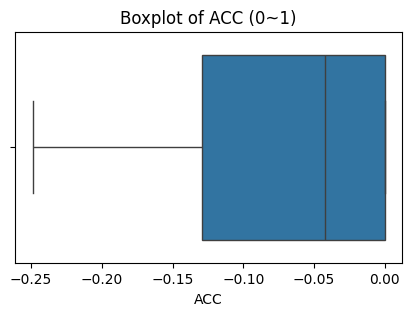

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df_processed.select_dtypes(include=[np.number]).columns



for col in numeric_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df_processed[col])
    plt.title(f"Boxplot of {col} (0~1)")
    plt.show()

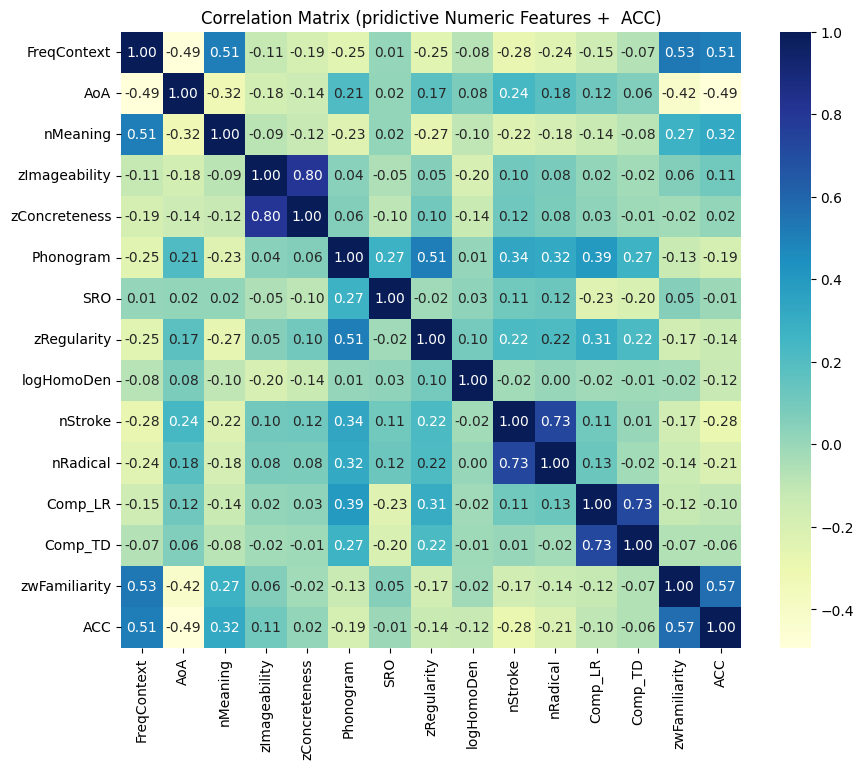

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#"Plot a heatmap


numeric_cols = df_processed.select_dtypes(include=[np.number]).columns


corr_matrix = df_processed[numeric_cols].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Correlation Matrix (pridictive Numeric Features +  ACC)")
plt.show()

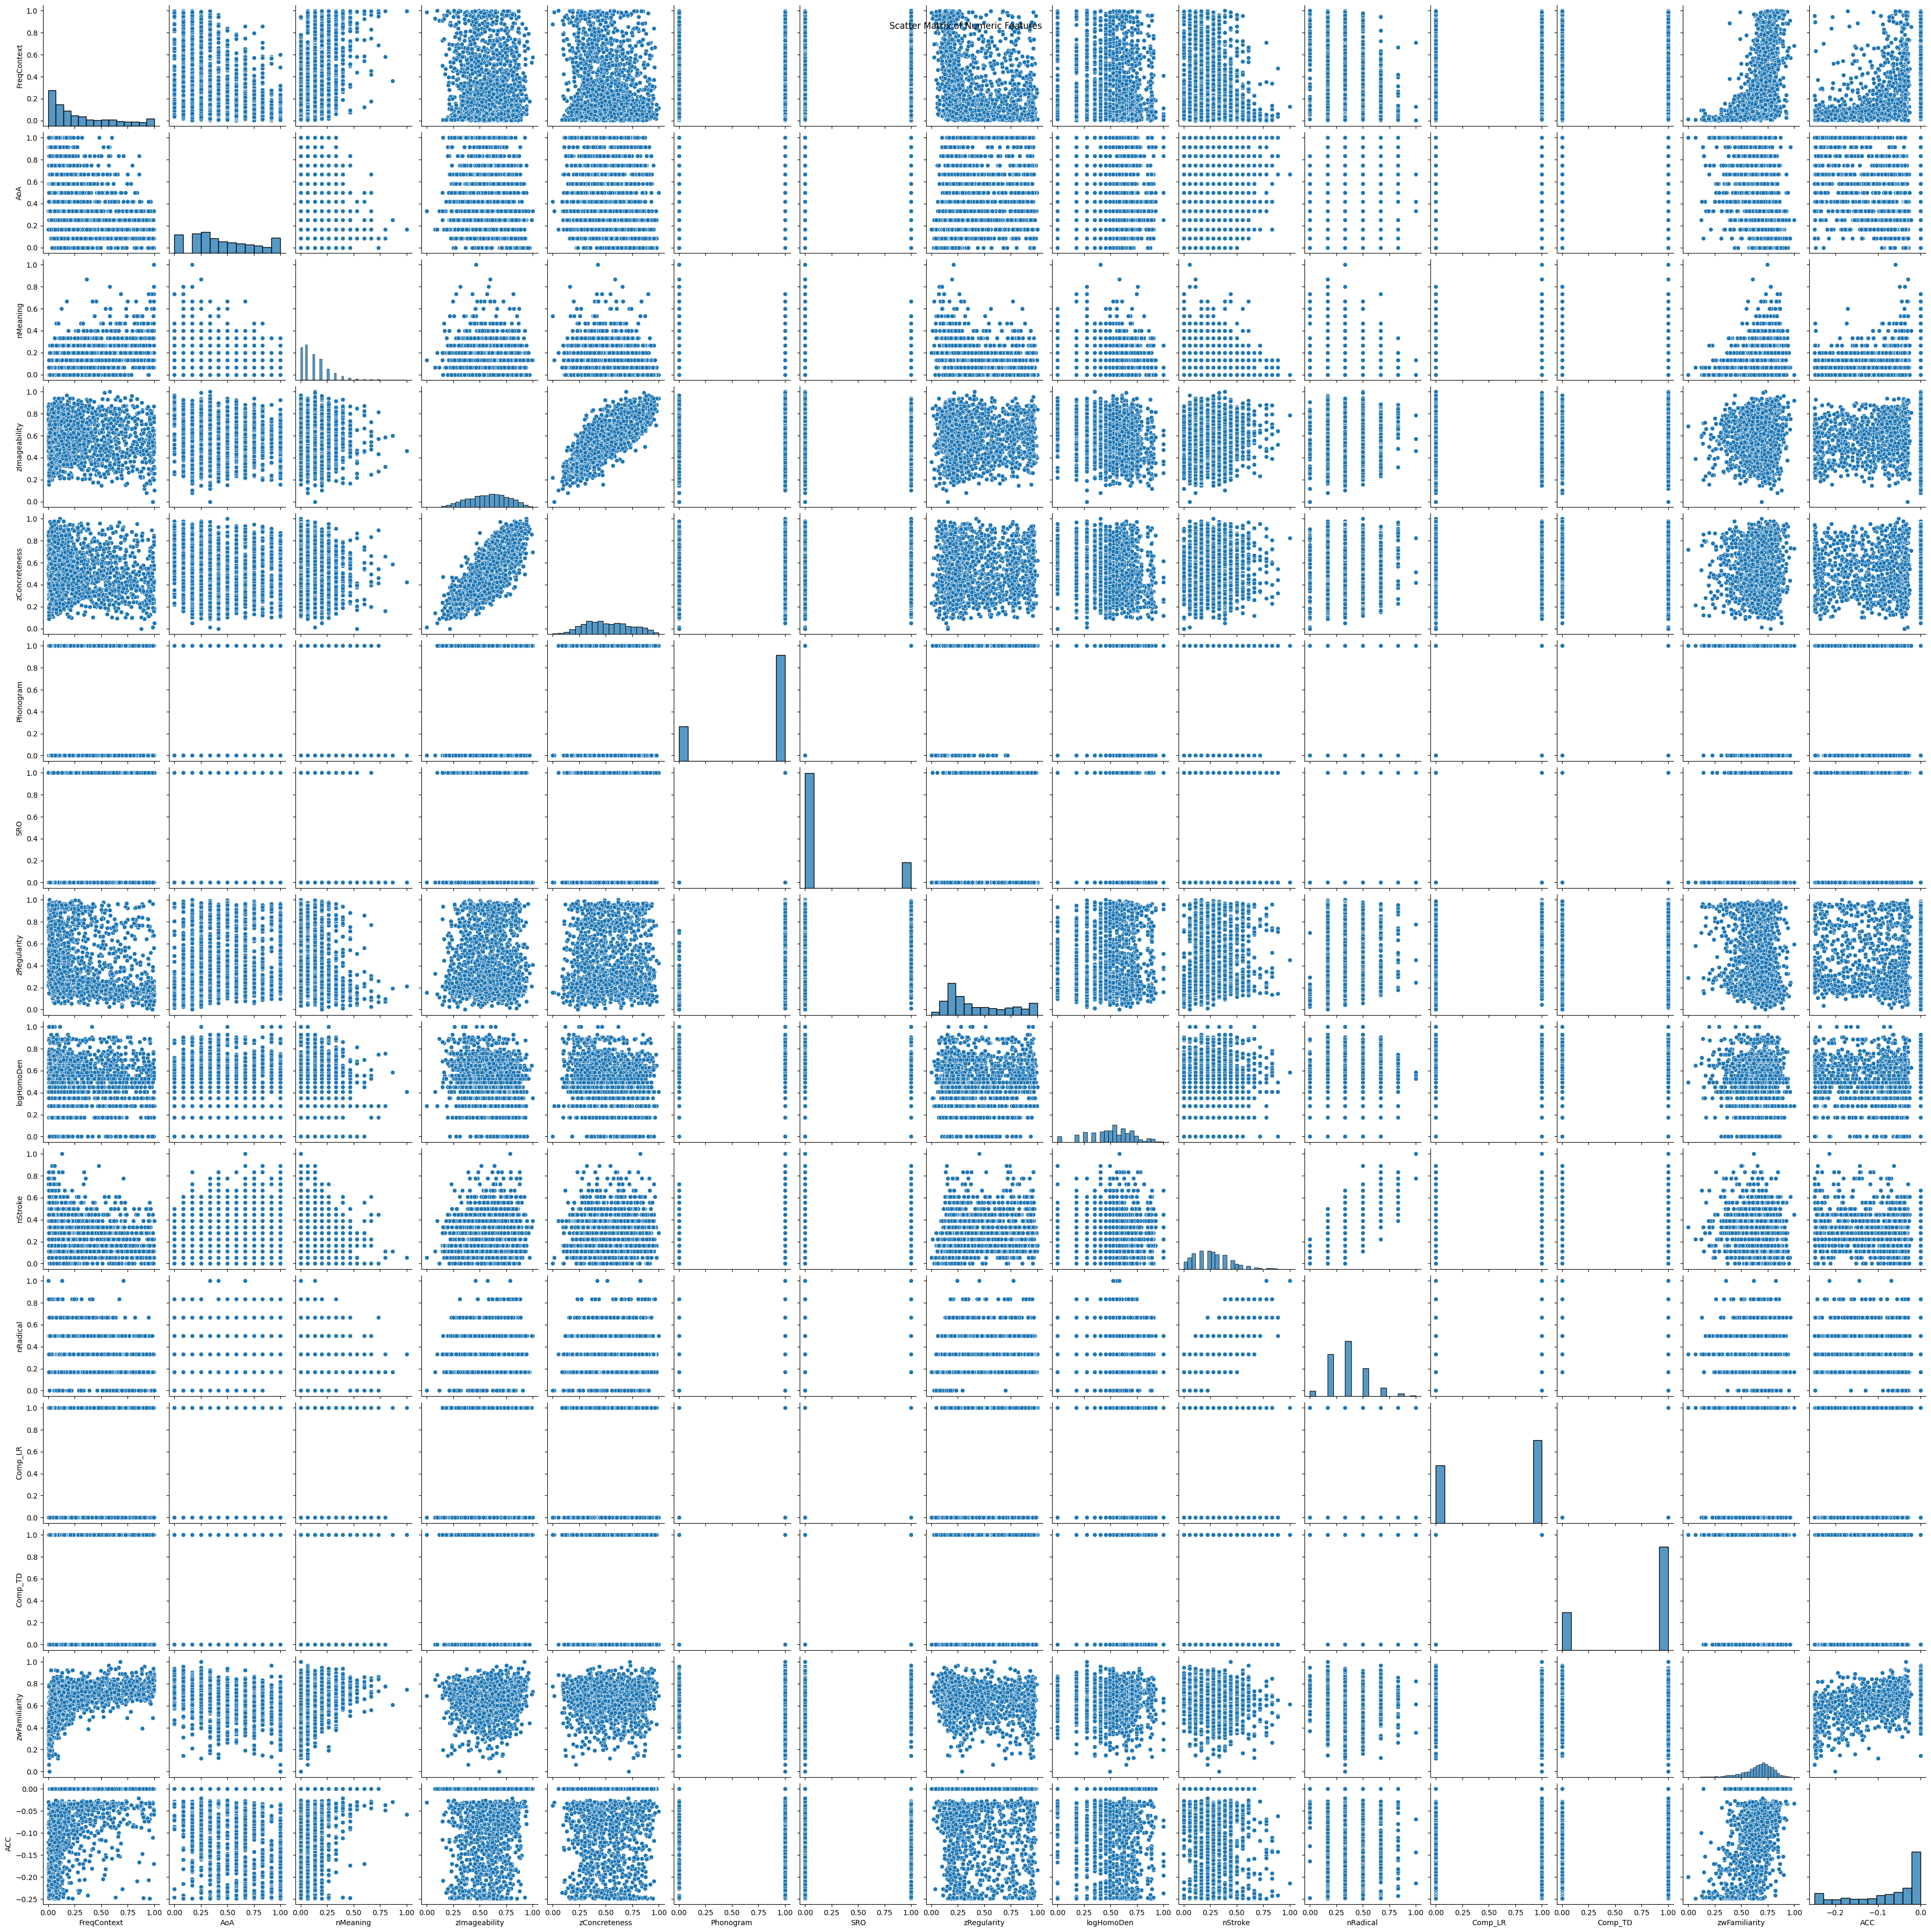

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter matrix plot
sns.pairplot(df_processed[numeric_cols])
plt.suptitle('Scatter Matrix of Numeric Features')
plt.show()


<Figure size 1000x800 with 0 Axes>

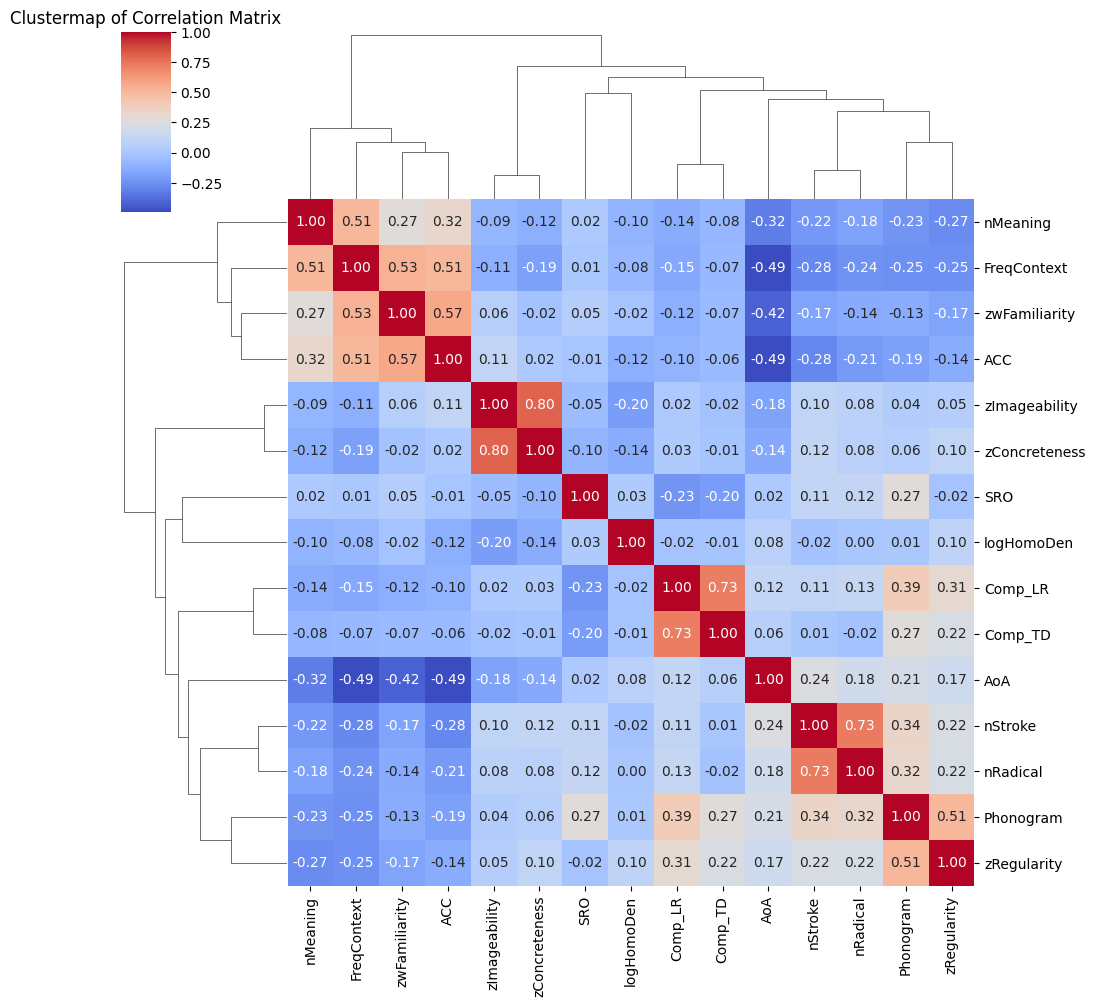

In [ ]:
plt.figure(figsize=(10, 8))
sns.clustermap(df_processed.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Clustermap of Correlation Matrix')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import shap
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  Construct Chinese Character Complexity Indicator
# Use normalized 'nStroke', 'nRadical', 'Comp_LR', and 'Comp_TD' to form a composite complexity indicator

df_processed['CompositeComplexity'] = (
    df_processed['nStroke'] +
    df_processed['nRadical'] +
    df_processed['Comp_LR'] +
    df_processed['Comp_TD']
) / 4.0


median_complexity = df_processed['CompositeComplexity'].median()
df_processed['Complexity'] = np.where(df_processed['CompositeComplexity'] >= median_complexity,
                                              'complex', 'simple')

df_processed.head()


FreqContext       AoA  nMeaning  zImageability  zConcreteness  Phonogram  \
0     0.119743  0.750000  0.133333       0.706227       0.488514        1.0   
1     0.098665  0.583333  0.000000       0.636563       0.618704        1.0   
2     0.067851  0.750000  0.066667       0.863608       0.883415        1.0   
3     0.963666  0.000000  0.333333       0.743862       0.733015        0.0   
4     0.547727  0.083333  0.066667       0.570661       0.448264        0.0   

   SRO  zRegularity  logHomoDen   nStroke  nRadical  Comp_LR  Comp_TD  \
0  1.0     0.057296    0.492480  0.222222  0.333333      0.0      1.0   
1  0.0     0.169344    0.350850  0.666667  0.666667      0.0      1.0   
2  0.0     0.969333    0.556084  0.222222  0.166667      0.0      1.0   
3  0.0     0.206635    0.175425  0.000000  0.000000      0.0      1.0   
4  0.0     0.698240    0.407324  0.055556  0.000000      0.0      1.0   

   zwFamiliarity       ACC  CompositeComplexity Complexity  
0       0.647149 -0.036287             0.388889     simple  
1       0.602329 -0.158247             0.583333    complex  
2       0.643590 -0.042432             0.347222     simple  
3       0.785615  0.000001             0.250000     simple  
4       0.795862  0.000001             0.263889     simple

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best hyperparameters: {'C': 1, 'epsilon': 0.01, 'gamma': 'auto'}
Best CV score (neg MAE): -0.04368810526228056

== 5-Fold Cross-Validation Overall Metrics ==
Fold 1 - MAE: 0.0411, MSE: 0.0029, RMSE: 0.0537, R²: 0.4884
Fold 2 - MAE: 0.0412, MSE: 0.0029, RMSE: 0.0535, R²: 0.5578
Fold 3 - MAE: 0.0471, MSE: 0.0038, RMSE: 0.0620, R²: 0.4668
Fold 4 - MAE: 0.0439, MSE: 0.0034, RMSE: 0.0583, R²: 0.4349
Fold 5 - MAE: 0.0453, MSE: 0.0038, RMSE: 0.0615, R²: 0.4984

== 5-Fold Cross-Validation Metrics (Split by Complexity) ==
Fold 1:
  Overall: MAE=0.0421, MSE=0.0030, RMSE=0.0545, R²=0.5334
  Simple:  MAE=0.0352, MSE=0.0023, RMSE=0.0478, R²=0.5913
  Complex: MAE=0.0486, MSE=0.0036, RMSE=0.0602, R²=0.4576
Fold 2:
  Overall: MAE=0.0433, MSE=0.0032, RMSE=0.0565, R²=0.5040
  Simple:  MAE=0.0396, MSE=0.0029, RMSE=0.0534, R²=0.4896
  Complex: MAE=0.0468, MSE=0.0035, RMSE=0.0593, R²=0.4891
Fold 3:
  Overall: MAE=0.0432, MSE=0.0032, RMSE=0.0565, 

  0%|          | 0/320 [00:00<?, ?it/s]

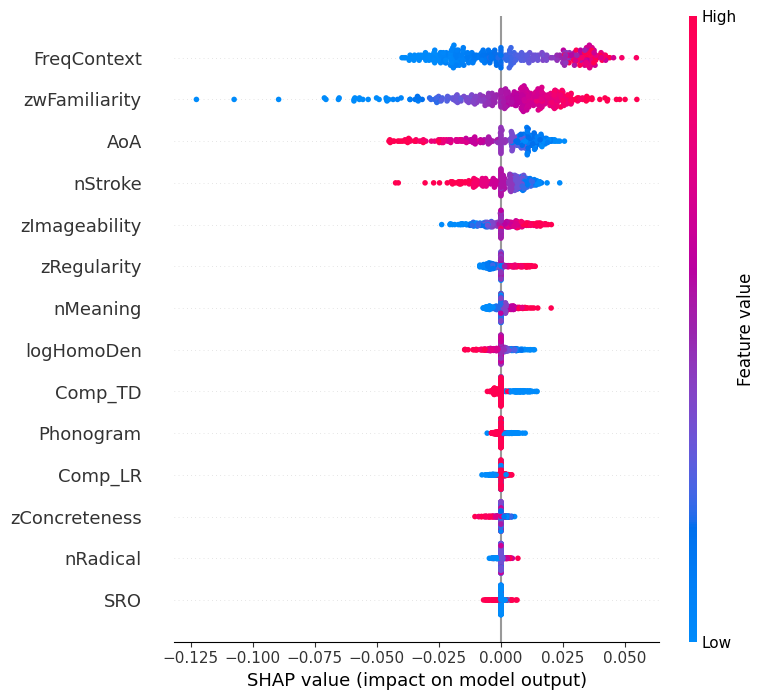


按平均绝对 SHAP 值排序的表格:
          Feature  Mean |SHAP Value|
0     FreqContext           0.021177
13  zwFamiliarity           0.018571
1             AoA           0.013200
9         nStroke           0.007770
3   zImageability           0.006674
7     zRegularity           0.004262
2        nMeaning           0.003240
8      logHomoDen           0.003232
12        Comp_TD           0.003068
5       Phonogram           0.001497
11        Comp_LR           0.001191
4   zConcreteness           0.001188
10       nRadical           0.000651
6             SRO           0.000559

== [A] Top 10 Characters with Largest Absolute Difference ==
HanZi: 右, Complexity: simple, ACC_true: -0.2414, Predicted: 0.0046, MAE: 0.2461, MSE: 0.0605, RMSE: 0.2461, R²: -1.0179
HanZi: 眼, Complexity: complex, ACC_true: -0.2097, Predicted: -0.0073, MAE: 0.2024, MSE: 0.0409, RMSE: 0.2024, R²: -1.0458
HanZi: 河, Complexity: complex, ACC_true: -0.2490, Predicted: -0.0470, MAE: 0.2020, MSE: 0.0408, RMSE: 0.2020, R²: -0.2479

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.svm import SVR

X = df_processed_normalized
y = df_processed['ACC']
complexity_labels = df_processed['Complexity']

# 80/20 stratified split
X_train, X_test, y_train, y_test, strat_train, strat_test = train_test_split(
    X, y, complexity_labels, test_size=0.2, random_state=42, stratify=complexity_labels
)

# ==============================================================================
# --- SVR model and hyperparameter grid search ---
# ==============================================================================
svr_model = SVR()
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(
    estimator=svr_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score (neg MAE):", grid_search.best_score_)

# Prediction using the best-performing model
best_svr = grid_search.best_estimator_
y_pred = best_svr.predict(X_test)

# ==============================================================================
# Overall cross-validation metrics (obtained using cross_validate)
# ==============================================================================
def rmse_func(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(rmse_func),
    'R2': make_scorer(r2_score)
}
cv_results = cross_validate(best_svr, X_train, y_train, cv=5, scoring=scoring)
print("\n== 5-Fold Cross-Validation Overall Metrics ==")
for i in range(5):
    print(f"Fold {i+1} - MAE: {cv_results['test_MAE'][i]:.4f}, "
          f"MSE: {cv_results['test_MSE'][i]:.4f}, "
          f"RMSE: {cv_results['test_RMSE'][i]:.4f}, "
          f"R²: {cv_results['test_R2'][i]:.4f}")

# ==============================================================================
# Cross-validation: per-fold metrics computed separately for easy and difficult groups
# ==============================================================================
print("\n== 5-Fold Cross-Validation Metrics (Split by Complexity) ==")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train_np = X_train.values
y_train_np = y_train.values
complexities_train_np = strat_train.values
fold_idx = 1
for train_idx, val_idx in skf.split(X_train_np, complexities_train_np):
    X_tr, X_val = X_train_np[train_idx], X_train_np[val_idx]
    y_tr, y_val = y_train_np[train_idx], y_train_np[val_idx]
    # An SVR model was constructed with the best hyperparameters and trained on the current fold
    svr_fold = SVR(**grid_search.best_params_)
    svr_fold.fit(X_tr, y_tr)
    y_val_pred = svr_fold.predict(X_val)
    overall_mae = mean_absolute_error(y_val, y_val_pred)
    overall_mse = mean_squared_error(y_val, y_val_pred)
    overall_rmse = np.sqrt(overall_mse)
    overall_r2 = r2_score(y_val, y_val_pred)
    complexities_val = complexities_train_np[val_idx]
    simple_mask = (complexities_val == 'simple')
    complex_mask = (complexities_val == 'complex')
    # Simple
    if simple_mask.sum() > 0:
        mae_simple = mean_absolute_error(y_val[simple_mask], y_val_pred[simple_mask])
        mse_simple = mean_squared_error(y_val[simple_mask], y_val_pred[simple_mask])
        rmse_simple = np.sqrt(mse_simple)
        r2_simple = r2_score(y_val[simple_mask], y_val_pred[simple_mask])
    else:
        mae_simple = mse_simple = rmse_simple = r2_simple = np.nan
    # Complex
    if complex_mask.sum() > 0:
        mae_complex = mean_absolute_error(y_val[complex_mask], y_val_pred[complex_mask])
        mse_complex = mean_squared_error(y_val[complex_mask], y_val_pred[complex_mask])
        rmse_complex = np.sqrt(mse_complex)
        r2_complex = r2_score(y_val[complex_mask], y_val_pred[complex_mask])
    else:
        mae_complex = mse_complex = rmse_complex = r2_complex = np.nan
    print(f"Fold {fold_idx}:")
    print(f"  Overall: MAE={overall_mae:.4f}, MSE={overall_mse:.4f}, RMSE={overall_rmse:.4f}, R²={overall_r2:.4f}")
    print(f"  Simple:  MAE={mae_simple:.4f}, MSE={mse_simple:.4f}, RMSE={rmse_simple:.4f}, R²={r2_simple:.4f}")
    print(f"  Complex: MAE={mae_complex:.4f}, MSE={mse_complex:.4f}, RMSE={rmse_complex:.4f}, R²={r2_complex:.4f}")
    fold_idx += 1

# ==============================================================================
# Overall evaluation on the test set
# ==============================================================================
test_mae = mean_absolute_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)
print("\nTest set evaluation metrics (using best hyperparameter model):")
print(f"Overall: MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

# Test-set metrics computed by complexity level
def evaluate_complexity(test_df, y_true, y_pred):
    complexities = test_df['Complexity'].values
    simple_mask = (complexities == 'simple')
    complex_mask = (complexities == 'complex')
    mae_simple = mean_absolute_error(y_true[simple_mask], y_pred[simple_mask])
    mse_simple = mean_squared_error(y_true[simple_mask], y_pred[simple_mask])
    rmse_simple = np.sqrt(mse_simple)
    r2_simple = r2_score(y_true[simple_mask], y_pred[simple_mask])
    mae_complex = mean_absolute_error(y_true[complex_mask], y_pred[complex_mask])
    mse_complex = mean_squared_error(y_true[complex_mask], y_pred[complex_mask])
    rmse_complex = np.sqrt(mse_complex)
    r2_complex = r2_score(y_true[complex_mask], y_pred[complex_mask])
    print("\n--- Test Set Evaluation by Complexity ---")
    print(f"Overall: MAE: {mean_absolute_error(y_true, y_pred):.4f}, "
          f"MSE: {mean_squared_error(y_true, y_pred):.4f}, "
          f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}, "
          f"R²: {r2_score(y_true, y_pred):.4f}")
    print(f"Simple:  MAE: {mae_simple:.4f}, MSE: {mse_simple:.4f}, "
          f"RMSE: {rmse_simple:.4f}, R²: {r2_simple:.4f}")
    print(f"Complex: MAE: {mae_complex:.4f}, MSE: {mse_complex:.4f}, "
          f"RMSE: {rmse_complex:.4f}, R²: {r2_complex:.4f}")

# -------- Important: define test_df so that evaluate_complexity(...) can be applied -----------
# Here, test_df is assumed to contain only the 'Complexity' column, with row indices aligned with X_test
test_df = pd.DataFrame({'Complexity': strat_test.values}, index=X_test.index)

# Call evaluate_complexity
evaluate_complexity(test_df, y_test, y_pred)

# ==============================================================================
# SHAP analysis
# ==============================================================================
background = X_train.sample(n=100, random_state=42)
explainer = shap.KernelExplainer(best_svr.predict, background)
shap_values = explainer.shap_values(X_test, nsamples=100)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=True)

mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean |SHAP Value|': mean_abs_shap
}).sort_values(by='Mean |SHAP Value|', ascending=False)
print("\n按平均绝对 SHAP 值排序的表格:")
print(shap_df)

# ==============================================================================
# Residual analysis: constructing test_data and computing per-sample metrics
# ==============================================================================
test_data = X_test.copy()
test_data['ACC_true'] = y_test
test_data['preds'] = y_pred
# Since test_df already contains the complexity information and shares the same index
test_data['Complexity'] = test_df['Complexity']
test_data['HanZi'] = test_data.index
test_data['residual'] = test_data['preds'] - test_data['ACC_true']
test_data['abs_diff'] = test_data['residual'].abs()
mean_true_val = test_data['ACC_true'].mean()

def single_sample_metrics(true_val, pred_val, global_mean):
    diff = pred_val - true_val
    mae_ = abs(diff)
    mse_ = diff ** 2
    rmse_ = np.sqrt(mse_)
    sse = mse_
    sst = (true_val - global_mean) ** 2
    r2_ = np.nan if sst == 0 else 1 - sse / sst
    return mae_, mse_, rmse_, r2_

# --- A. Top 10 samples with the largest absolute residuals ---
top10_abs = test_data.sort_values(by='abs_diff', ascending=False).head(10)
print("\n== [A] Top 10 Characters with Largest Absolute Difference ==")
for idx, row in top10_abs.iterrows():
    mae_, mse_, rmse_, r2_ = single_sample_metrics(row['ACC_true'], row['preds'], mean_true_val)
    # Retrieve the corresponding Chinese characters from an external DataFrame df using the character identifiers (row indices)
    character = df.loc[row['HanZi'], 'Character']
    print(f"HanZi: {character}, Complexity: {row['Complexity']}, "
          f"ACC_true: {row['ACC_true']:.4f}, Predicted: {row['preds']:.4f}, "
          f"MAE: {mae_:.4f}, MSE: {mse_:.4f}, RMSE: {rmse_:.4f}, R²: {r2_:.4f}")

# --- B.Top 10 overestimated samples (prediction > ground truth) ---
over_pred = test_data[test_data['residual'] > 0].sort_values(by='residual', ascending=False).head(10)
print("\n== [B] Top 10 Characters where Predicted > Actual (Overestimation) ==")
for idx, row in over_pred.iterrows():
    mae_, mse_, rmse_, r2_ = single_sample_metrics(row['ACC_true'], row['preds'], mean_true_val)
    character = df.loc[row['HanZi'], 'Character']
    print(f"HanZi: {character}, Complexity: {row['Complexity']}, "
          f"ACC_true: {row['ACC_true']:.4f}, Predicted: {row['preds']:.4f}, "
          f"MAE: {mae_:.4f}, MSE: {mse_:.4f}, RMSE: {rmse_:.4f}, R²: {r2_:.4f}")

# --- C. Top 10 underestimated samples (prediction < ground truth) ---
under_pred = test_data[test_data['residual'] < 0].copy()
under_pred['deficit'] = under_pred['ACC_true'] - under_pred['preds']
under_pred = under_pred.sort_values(by='deficit', ascending=False).head(10)
print("\n== [C] Top 10 Characters where Actual > Predicted (Underestimation) ==")
for idx, row in under_pred.iterrows():
    mae_, mse_, rmse_, r2_ = single_sample_metrics(row['ACC_true'], row['preds'], mean_true_val)
    character = df.loc[row['HanZi'], 'Character']
    print(f"HanZi: {character}, Complexity: {row['Complexity']}, "
          f"ACC_true: {row['ACC_true']:.4f}, Predicted: {row['preds']:.4f}, "
          f"MAE: {mae_:.4f}, MSE: {mse_:.4f}, RMSE: {rmse_:.4f}, R²: {r2_:.4f}")



In [ ]:


#  Display the results of test set
df_results = X_test.copy()


df_results['ACC_Actual'] = y_test


df_results['ACC_Predicted'] = y_pred


df_results['ACC_Residual'] = df_results['ACC_Actual'] - df_results['ACC_Predicted']


df_results


FreqContext       AoA  nMeaning  zImageability  zConcreteness  \
358      0.241192  0.500000  0.133333       0.556373       0.467710   
330      0.069557  0.500000  0.266667       0.745461       0.753990   
146      0.708522  0.166667  0.200000       0.622122       0.557676   
1361     0.014755  0.833333  0.066667       0.290320       0.177645   
413      0.187795  0.250000  0.200000       0.711958       0.722990   
...           ...       ...       ...            ...            ...   
828      0.041654  0.333333  0.200000       0.316628       0.216510   
752      0.097059  0.333333  0.066667       0.769750       0.726104   
152      0.443441  0.416667  0.066667       0.460010       0.360788   
1478     0.723778  0.250000  0.200000       0.673312       0.668423   
1330     0.006223  0.416667  0.000000       0.517342       0.719913   

      Phonogram  SRO  zRegularity  logHomoDen   nStroke  nRadical  Comp_LR  \
358         1.0  0.0     0.289262    0.278042  0.222222  0.333333      0.0   
330         1.0  1.0     0.265233    0.526275  0.500000  0.666667      0.0   
146         0.0  0.0     0.094339    0.628892  0.111111  0.000000      0.0   
1361        1.0  0.0     0.907954    0.492480  0.333333  0.500000      1.0   
413         1.0  0.0     0.127248    0.175425  0.277778  0.333333      0.0   
...         ...  ...          ...         ...       ...       ...      ...   
828         1.0  0.0     0.562161    0.453467  0.111111  0.166667      1.0   
752         1.0  0.0     0.280804    0.175425  0.388889  0.333333      1.0   
152         1.0  1.0     0.844360    0.667905  0.277778  0.166667      0.0   
1478        1.0  1.0     0.537837    0.278042  0.555556  0.666667      1.0   
1330        1.0  0.0     0.250692    0.492480  0.277778  0.333333      1.0   

      Comp_TD  zwFamiliarity  ACC_Actual  ACC_Predicted  ACC_Residual  
358       0.0       0.525940   -0.111807      -0.075150     -0.036658  
330       0.0       0.576858   -0.248057      -0.118811     -0.129246  
146       1.0       0.726467    0.000001      -0.004109      0.004110  
1361      1.0       0.633283   -0.056852      -0.145292      0.088440  
413       0.0       0.589352    0.000001      -0.054450      0.054451  
...       ...            ...         ...            ...           ...  
828       1.0       0.612507   -0.118222      -0.094556     -0.023666  
752       1.0       0.665832   -0.114929      -0.068547     -0.046382  
152       1.0       0.725233   -0.035019      -0.033380     -0.001638  
1478      1.0       0.891178    0.000001       0.019013     -0.019012  
1330      1.0       0.519765   -0.158247      -0.144861     -0.013386  

[320 rows x 17 columns]

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from PIL import Image, ImageDraw, ImageFont


def text_to_image_and_save(text, save_folder,
                           font_path='simsun.ttc',
                           img_size=(64, 64),
                           font_size=36):

    # if there is no fold then create one
    if not os.path.exists(save_folder):
        os.makedirs(save_folder, exist_ok=True)

    img = Image.new('L', img_size, color=255)
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype(font_path, font_size)
    except Exception as e:
        print("Failed to load font, using default font:", e)
        font = ImageFont.load_default()

    # setting text size
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    x = (img_size[0] - text_width) // 2
    y = (img_size[1] - text_height) // 2

    draw.text((x, y), text, fill=0, font=font)

    # files named "text.png"
    filename = f"{text}.png"
    save_path = os.path.join(save_folder, filename)
    img.save(save_path)


image_folder = "words"

characters = df_Character["Character"]
for char in characters:
    text_to_image_and_save(
        text=char,
        save_folder=image_folder,
        font_path="simsun.ttc",
        img_size=(64, 64),
        font_size=36
    )

df_processed_picture=pd.concat([df[features_Character], df_target['ACC'],df_processed['Complexity']], axis=1)
df_processed_picture

Character       ACC Complexity
0            哀 -0.036287     simple
1            癌 -0.158247    complex
2            疤 -0.042432     simple
3            白  0.000001     simple
4            百  0.000001     simple
...        ...       ...        ...
1595         组 -0.154470    complex
1596         钻 -0.037651    complex
1597         嘴 -0.055288    complex
1598         醉 -0.066203    complex
1599         作  0.000001     simple

[1600 rows x 3 columns]

In [ ]:
class ChineseCharacterImageDataset(Dataset):
    def __init__(self, df, image_folder, transform=None):
        # Reset the DataFrame index and store the parameters
        self.df = df.reset_index(drop=True)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.df)

    def __getitem__(self, idx):
        # Get the row corresponding to the current index
        row = self.df.iloc[idx]
        char = row['Character']
        img_path = os.path.join(self.image_folder, f"{char}.png")

        # Load the image and convert it to grayscale
        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)

        # Get the target (ACC) as a float tensor
        target = torch.tensor(row['ACC'], dtype=torch.float32)

        # Return the image, target, and the complexity label (for possible classification)
        return img, target, row['Complexity']




In [ ]:

class CNNRegression(nn.Module):
    def __init__(self):
        super(CNNRegression, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # For 64x64 input, two poolings result in 16x16 feature maps.
        self.fc1   = nn.Linear(64 * 16 * 16, 128)
        self.fc2   = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        out = self.fc2(x)
        return out

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =============================================
# 0. First, unify the row indices of df as strings to avoid KeyError
# =============================================
df = df_processed_picture.copy()
df.index = df.index.map(str)  # Convert row indices to strings
# At this point, df.index consists of a sequence of strings

# =============================================
# 1. Dataset definition (image loading, ACC, complexity, and HanZiKey)
# =============================================
class ChineseCharacterImageDataset(Dataset):
    def __init__(self, df, image_folder, transform=None):
        """
        df：DataFrame，行索引已是字符串(如 '100','101'，或 'char001')。
        我们把 df 的行索引复制到 'HanZiKey' 列里，供后续 df.loc[...] 查询。
        """
        df_fixed = df.copy()
        df_fixed['HanZiKey'] = df_fixed.index  # 索引是字符串
        df_fixed = df_fixed.reset_index(drop=True)

        self.df = df_fixed
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        hanzi_key = row['HanZiKey']   # (str)
        char = row['Character']       # 图片文件名
        img_path = os.path.join(self.image_folder, f"{char}.png")

        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)

        target = torch.tensor(row['ACC'], dtype=torch.float32)
        complexity = row['Complexity']
        return img, target, complexity, hanzi_key


# =============================================
# 2.Define the CNN regression model
# =============================================
class CNNRegression(nn.Module):
    def __init__(self):
        super(CNNRegression, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # 输入 64x64 -> 池化2次 -> 16x16
        self.fc1   = nn.Linear(64*16*16, 128)
        self.fc2   = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        out = self.fc2(x)
        return out

# =============================================
# 3. Define the training function (grid search)
# =============================================
def train_model_grid(train_dataset, val_dataset, learning_rate, batch_size, num_epochs, device):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = CNNRegression().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # train
    for epoch in range(num_epochs):
        model.train()
        for imgs, targets, comp, hanzi_key in train_loader:
            imgs = imgs.to(device)
            targets = targets.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for imgs, targets, comp, hanzi_key in val_loader:
            imgs = imgs.to(device)
            targets = targets.to(device).unsqueeze(1)
            outputs = model(imgs)
            val_loss = criterion(outputs, targets).item()
            val_losses.append(val_loss)
    avg_val_loss = np.mean(val_losses)
    return avg_val_loss, model


# =============================================
# 4. Dataset split: training / validation / test
# =============================================
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['Complexity']
)
train_df_grid, val_df_grid = train_test_split(
    train_df, test_size=0.2, random_state=42, stratify=train_df['Complexity']
)
print(f"Training set size: {len(train_df)}, Testing set size: {len(test_df)}")

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])
image_folder = "words"

train_dataset_grid = ChineseCharacterImageDataset(train_df_grid, image_folder, transform=transform)
val_dataset_grid   = ChineseCharacterImageDataset(val_df_grid,   image_folder, transform=transform)

# =============================================
# 5. Grid search
# =============================================
param_grid = {
    'learning_rate': [1e-3, 5e-4],
    'batch_size': [16, 32],
    'num_epochs': [5, 10]
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_val_loss = float('inf')
best_params   = {}
best_model    = None

for lr in param_grid['learning_rate']:
    for bs in param_grid['batch_size']:
        for ne in param_grid['num_epochs']:
            print(f"\nTraining with lr={lr}, batch_size={bs}, num_epochs={ne}")
            val_loss, model_tmp = train_model_grid(
                train_dataset_grid, val_dataset_grid,
                lr, bs, ne, device
            )
            print(f"Validation loss: {val_loss:.4f}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {'learning_rate': lr, 'batch_size': bs, 'num_epochs': ne}
                best_model = model_tmp

print("\nBest hyperparameters:", best_params)
print("Best validation loss:", best_val_loss)

# =============================================
# 6. Five-fold cross-validation (overall + simple/complex)
# =============================================
from sklearn.model_selection import StratifiedKFold

print("\n== 5-Fold Cross-Validation Overall Metrics ==")
full_train_df = pd.concat([train_df_grid, val_df_grid], axis=0)

def rmse_func(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_idx = 1
for tr_idx, va_idx in skf.split(full_train_df, full_train_df['Complexity']):
    subtrain_df = full_train_df.iloc[tr_idx]
    subval_df   = full_train_df.iloc[va_idx]

    subtrain_ds = ChineseCharacterImageDataset(subtrain_df, image_folder, transform=transform)
    subval_ds   = ChineseCharacterImageDataset(subval_df,   image_folder, transform=transform)

    fold_model = CNNRegression().to(device)
    optimizer  = optim.Adam(fold_model.parameters(), lr=best_params['learning_rate'])
    criterion  = nn.MSELoss()

    train_loader_ = DataLoader(subtrain_ds, batch_size=best_params['batch_size'], shuffle=True)
    for ep in range(best_params['num_epochs']):
        fold_model.train()
        for imgs, targets, comp, hanzi_key in train_loader_:
            imgs = imgs.to(device)
            targets = targets.to(device).unsqueeze(1)
            optimizer.zero_grad()
            out = fold_model(imgs)
            loss = criterion(out, targets)
            loss.backward()
            optimizer.step()

    # Validation
    val_loader_ = DataLoader(subval_ds, batch_size=best_params['batch_size'], shuffle=False)
    y_val_list, preds_val_list, comp_val_list = [], [], []
    fold_model.eval()
    with torch.no_grad():
        for imgs, targets, comp, hanzi_key in val_loader_:
            imgs = imgs.to(device)
            out = fold_model(imgs).cpu().numpy().flatten()
            y_val_list.extend(targets.numpy().flatten())
            preds_val_list.extend(out)
            comp_val_list.extend(comp)

    mae_  = mean_absolute_error(y_val_list, preds_val_list)
    mse_  = mean_squared_error(y_val_list, preds_val_list)
    rmse_ = np.sqrt(mse_)
    r2_   = r2_score(y_val_list, preds_val_list)
    print(f"Fold {fold_idx} - MAE={mae_:.4f}, MSE={mse_:.4f}, RMSE={rmse_:.4f}, R²={r2_:.4f}")
    fold_idx += 1

#  simple / complex
print("\n== 5-Fold Cross-Validation Metrics (Split by Complexity) ==")
fold_idx2=1
skf2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for tr_idx2, va_idx2 in skf2.split(full_train_df, full_train_df['Complexity']):
    subtrain_df2 = full_train_df.iloc[tr_idx2]
    subval_df2   = full_train_df.iloc[va_idx2]

    subtrain_ds2 = ChineseCharacterImageDataset(subtrain_df2, image_folder, transform=transform)
    subval_ds2   = ChineseCharacterImageDataset(subval_df2,   image_folder, transform=transform)

    fold_model2 = CNNRegression().to(device)
    optimizer2  = optim.Adam(fold_model2.parameters(), lr=best_params['learning_rate'])
    criterion2  = nn.MSELoss()

    train_loader_2 = DataLoader(subtrain_ds2, batch_size=best_params['batch_size'], shuffle=True)
    for ep in range(best_params['num_epochs']):
        fold_model2.train()
        for imgs, targets, comp, hanzi_key in train_loader_2:
            imgs = imgs.to(device)
            targets = targets.to(device).unsqueeze(1)
            optimizer2.zero_grad()
            out = fold_model2(imgs)
            loss = criterion2(out, targets)
            loss.backward()
            optimizer2.step()

    val_loader_2 = DataLoader(subval_ds2, batch_size=best_params['batch_size'], shuffle=False)
    yv2_list, pv2_list, compv2_list = [], [], []
    fold_model2.eval()
    with torch.no_grad():
        for imgs, targets, comp, hanzi_key in val_loader_2:
            imgs = imgs.to(device)
            out = fold_model2(imgs).cpu().numpy().flatten()
            yv2_list.extend(targets.numpy().flatten())
            pv2_list.extend(out)
            compv2_list.extend(comp)

    mae_all  = mean_absolute_error(yv2_list, pv2_list)
    mse_all  = mean_squared_error(yv2_list, pv2_list)
    rmse_all = np.sqrt(mse_all)
    r2_all   = r2_score(yv2_list, pv2_list)

    comp_arr = np.array(compv2_list)
    y_val_ar = np.array(yv2_list)
    p_val_ar = np.array(pv2_list)
    simple_mask  = (comp_arr=='simple')
    complex_mask = (comp_arr=='complex')

    if np.any(simple_mask):
        mae_s  = mean_absolute_error(y_val_ar[simple_mask], p_val_ar[simple_mask])
        mse_s  = mean_squared_error(y_val_ar[simple_mask], p_val_ar[simple_mask])
        rmse_s = np.sqrt(mse_s)
        r2_s   = r2_score(y_val_ar[simple_mask], p_val_ar[simple_mask])
    else:
        mae_s=mse_s=rmse_s=r2_s=np.nan

    if np.any(complex_mask):
        mae_c  = mean_absolute_error(y_val_ar[complex_mask], p_val_ar[complex_mask])
        mse_c  = mean_squared_error(y_val_ar[complex_mask], p_val_ar[complex_mask])
        rmse_c = np.sqrt(mse_c)
        r2_c   = r2_score(y_val_ar[complex_mask], p_val_ar[complex_mask])
    else:
        mae_c=mse_c=rmse_c=r2_c=np.nan

    print(f"Fold {fold_idx2}:")
    print(f"  Overall: MAE={mae_all:.4f}, MSE={mse_all:.4f}, RMSE={rmse_all:.4f}, R²={r2_all:.4f}")
    print(f"  Simple:  MAE={mae_s:.4f}, MSE={mse_s:.4f}, RMSE={rmse_s:.4f}, R²={r2_s:.4f}")
    print(f"  Complex: MAE={mae_c:.4f}, MSE={mse_c:.4f}, RMSE={rmse_c:.4f}, R²={r2_c:.4f}")
    fold_idx2+=1

# =============================================
# 7. Test set evaluation with group-wise metrics
# =============================================
print("\nTest set evaluation metrics (using best hyperparameter model):")
test_dataset = ChineseCharacterImageDataset(test_df, image_folder, transform=transform)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

best_model.eval()
preds, trues, complexities, hanzi_keys = [], [], [], []
with torch.no_grad():
    for imgs, targets, comp, hanzi_key in test_loader:
        imgs = imgs.to(device)
        out  = best_model(imgs).cpu().numpy().flatten()
        preds.extend(out)
        trues.extend(targets.numpy().flatten())
        complexities.extend(comp)
        hanzi_keys.extend(hanzi_key)

mae  = mean_absolute_error(trues, preds)
mse  = mean_squared_error(trues, preds)
rmse = np.sqrt(mse)
r2   = r2_score(trues, preds)
print(f"Overall: MAE= {mae:.4f}, MSE= {mse:.4f}, RMSE= {rmse:.4f}, R²= {r2:.4f}")

def evaluate_complexity(comps, y_true, y_pred):
    c_arr = np.array(comps)
    t_arr = np.array(y_true)
    p_arr = np.array(y_pred)

    mae_all  = mean_absolute_error(t_arr, p_arr)
    mse_all  = mean_squared_error(t_arr, p_arr)
    rmse_all = np.sqrt(mse_all)
    r2_all   = r2_score(t_arr, p_arr)

    sim_mask = (c_arr=='simple')
    cpl_mask = (c_arr=='complex')

    if np.any(sim_mask):
        mae_s  = mean_absolute_error(t_arr[sim_mask], p_arr[sim_mask])
        mse_s  = mean_squared_error(t_arr[sim_mask], p_arr[sim_mask])
        rmse_s = np.sqrt(mse_s)
        r2_s   = r2_score(t_arr[sim_mask], p_arr[sim_mask])
    else:
        mae_s=mse_s=rmse_s=r2_s=np.nan

    if np.any(cpl_mask):
        mae_c  = mean_absolute_error(t_arr[cpl_mask], p_arr[cpl_mask])
        mse_c  = mean_squared_error(t_arr[cpl_mask], p_arr[cpl_mask])
        rmse_c = np.sqrt(mse_c)
        r2_c   = r2_score(t_arr[cpl_mask], p_arr[cpl_mask])
    else:
        mae_c=mse_c=rmse_c=r2_c=np.nan

    print("\n== Test Set Evaluation by Complexity ==")
    print(f"Overall: MAE= {mae_all:.4f}, MSE= {mse_all:.4f}, RMSE= {rmse_all:.4f}, R²= {r2_all:.4f}")
    print(f"Simple:  MAE= {mae_s:.4f}, MSE= {mse_s:.4f}, RMSE= {rmse_s:.4f}, R²= {r2_s:.4f}")
    print(f"Complex: MAE= {mae_c:.4f}, MSE= {mse_c:.4f}, RMSE= {rmse_c:.4f}, R²= {r2_c:.4f}")

evaluate_complexity(complexities, trues, preds)

# =============================================
# 8. Residual analysis
# =============================================
print("\n== [A] Top 10 Characters with Largest Absolute Difference ==")
records = []
mean_true_val = np.mean(trues)

def single_sample_metrics(true_val, pred_val, global_mean):
    diff = pred_val - true_val
    mae_ = abs(diff)
    mse_ = diff ** 2
    rmse_ = np.sqrt(mse_)
    sse = mse_
    sst = (true_val - global_mean) ** 2
    r2_ = np.nan if sst == 0 else 1 - sse/sst
    return mae_, mse_, rmse_, r2_

# Organize all test sample records
for i in range(len(trues)):
    mae_, mse_, rmse_, r2_ = single_sample_metrics(trues[i], preds[i], mean_true_val)
    # Retrieve the actual Chinese character from an external DataFrame df using hanzi_keys[i] (with df.index as strings)
    character = df.loc[hanzi_keys[i], 'Character']
    rec = {
        'HanZi': hanzi_keys[i],
        'Character': character,
        'ACC_true': trues[i],
        'preds': preds[i],
        'Complexity': complexities[i],
        'residual': preds[i] - trues[i],
        'abs_diff': abs(preds[i] - trues[i]),
        'MAE': mae_,
        'MSE': mse_,
        'RMSE': rmse_,
        'R2': r2_,
    }
    records.append(rec)

test_data = pd.DataFrame(records)

# --- A. Top 10 samples with the largest absolute residuals ---
top10_abs = test_data.sort_values(by='abs_diff', ascending=False).head(10)
print("\n== [A] Top 10 Characters with Largest Absolute Difference ==")
for idx, row in top10_abs.iterrows():
    mae_, mse_, rmse_, r2_ = single_sample_metrics(row['ACC_true'], row['preds'], mean_true_val)
    # Retrieve the corresponding Chinese characters from an external DataFrame df using the character identifiers (row indices)
    character = df.loc[row['HanZi'], 'Character']
    print(f"HanZi: {character}, Complexity: {row['Complexity']}, "
          f"ACC_true: {row['ACC_true']:.4f}, Predicted: {row['preds']:.4f}, "
          f"MAE: {mae_:.4f}, MSE: {mse_:.4f}, RMSE: {rmse_:.4f}, R²: {r2_:.4f}")

# --- B. Top 10 overestimated samples (prediction > ground truth) ---
over_pred = test_data[test_data['residual'] > 0].sort_values(by='residual', ascending=False).head(10)
print("\n== [B] Top 10 Characters where Predicted > Actual (Overestimation) ==")
for idx, row in over_pred.iterrows():
    mae_, mse_, rmse_, r2_ = single_sample_metrics(row['ACC_true'], row['preds'], mean_true_val)
    character = df.loc[row['HanZi'], 'Character']
    print(f"HanZi: {character}, Complexity: {row['Complexity']}, "
          f"ACC_true: {row['ACC_true']:.4f}, Predicted: {row['preds']:.4f}, "
          f"MAE: {mae_:.4f}, MSE: {mse_:.4f}, RMSE: {rmse_:.4f}, R²: {r2_:.4f}")

# --- C. Top 10 underestimated samples (prediction < ground truth) ---
under_pred = test_data[test_data['residual'] < 0].copy()
under_pred['deficit'] = under_pred['ACC_true'] - under_pred['preds']
under_pred = under_pred.sort_values(by='deficit', ascending=False).head(10)
print("\n== [C] Top 10 Characters where Actual > Predicted (Underestimation) ==")
for idx, row in under_pred.iterrows():
    mae_, mse_, rmse_, r2_ = single_sample_metrics(row['ACC_true'], row['preds'], mean_true_val)
    character = df.loc[row['HanZi'], 'Character']
    print(f"HanZi: {character}, Complexity: {row['Complexity']}, "
          f"ACC_true: {row['ACC_true']:.4f}, Predicted: {row['preds']:.4f}, "
          f"MAE: {mae_:.4f}, MSE: {mse_:.4f}, RMSE: {rmse_:.4f}, R²: {r2_:.4f}")




Training set size: 1280, Testing set size: 320

Training with lr=0.001, batch_size=16, num_epochs=5
Validation loss: 0.0078

Training with lr=0.001, batch_size=16, num_epochs=10
Validation loss: 0.0064

Training with lr=0.001, batch_size=32, num_epochs=5
Validation loss: 0.0063

Training with lr=0.001, batch_size=32, num_epochs=10
Validation loss: 0.0063

Training with lr=0.0005, batch_size=16, num_epochs=5
Validation loss: 0.0061

Training with lr=0.0005, batch_size=16, num_epochs=10
Validation loss: 0.0068

Training with lr=0.0005, batch_size=32, num_epochs=5
Validation loss: 0.0062

Training with lr=0.0005, batch_size=32, num_epochs=10
Validation loss: 0.0066

Best hyperparameters: {'learning_rate': 0.0005, 'batch_size': 16, 'num_epochs': 5}
Best validation loss: 0.006101235805545002

== 5-Fold Cross-Validation Overall Metrics ==
Fold 1 - MAE=0.0701, MSE=0.0065, RMSE=0.0806, R²=0.0540
Fold 2 - MAE=0.0692, MSE=0.0061, RMSE=0.0779, R²=0.0174
Fold 3 - MAE=0.0660, MSE=0.0069, RMSE=0.082

# three Ensemble models

Minimum value of 'ACC': 0.0
Lambda for Box-Cox transformation: 4.015924094155453


<ipython-input-21-f772e4564a6e>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['ACC'] = df_target['ACC'] - min_val + 1e-6  # Shift by (-min_val + a small epsilon)
<ipython-input-21-f772e4564a6e>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['ACC'] = data_bc


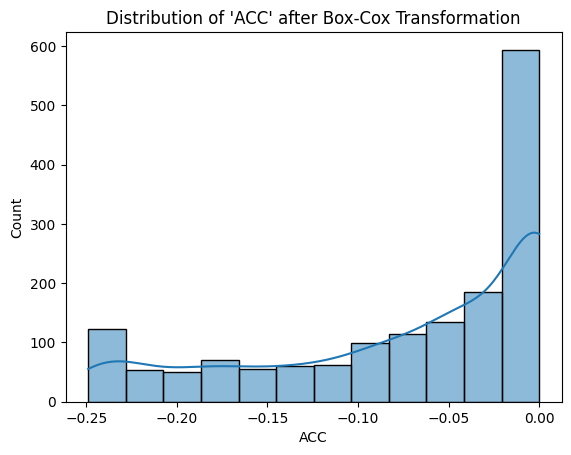

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import shap
import itertools
import seaborn as sns
from scipy.stats import boxcox

from scipy import stats
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from scipy import stats
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from PIL import Image, ImageDraw, ImageFont
from scipy.stats import boxcox

# Read Excel data
file_path = 'Database.xlsx'
sheet_name = 'Data'
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Select specific features
pridictive_features = [
    'FreqContext', 'AoA', 'nMeaning', 'zImageability', 'zConcreteness',
    'Phonogram', 'SRO', 'zRegularity', 'logHomoDen', 'nStroke', 'nRadical',
    'Comp_LR', 'Comp_TD', 'zwFamiliarity'
]


# Select predictive features (DataFrame)
pridictive_features = df[pridictive_features]

# Select the target column (ACC)
target_columns = ['ACC']
df_target = df[target_columns]

# Select character features (later use)
features_Character = ['Character']
df_Character = df[features_Character]

# Check the minimum value of 'ACC'
min_val = df_target['ACC'].min()
print("Minimum value of 'ACC':", min_val)

#  If the minimum value is <= 0, shift the data to make all values strictly positive
if min_val <= 0:
    df_target['ACC'] = df_target['ACC'] - min_val + 1e-6  # Shift by (-min_val + a small epsilon)

#  Apply Box-Cox transformation using scipy.stats.boxcox
data_bc, lam = stats.boxcox(df_target['ACC'])

#  Store the transformed data back into the DataFrame
df_target['ACC'] = data_bc
print("Lambda for Box-Cox transformation:", lam)

#  Combine the processed target with the predictive features
df_processed = pd.concat([pridictive_features, df_target['ACC']], axis=1)

#  Plot the distribution of the transformed 'ACC'
sns.histplot(df_processed['ACC'], kde=True)
plt.title("Distribution of 'ACC' after Box-Cox Transformation")
plt.show()

features_Character = ['Character']
df_Character = df[features_Character]

df_processed_normalized = pridictive_features.copy()
scaler = MinMaxScaler()
arr_scaled = scaler.fit_transform(df_processed_normalized)

df_processed_normalized = pd.DataFrame(
    arr_scaled,
    columns=pridictive_features.columns,
    index=pridictive_features.index
)


df_processed_normalized = df_processed_normalized.select_dtypes(include=[np.number])


df_processed_normalized = df_processed_normalized.replace([np.inf, -np.inf], np.nan)


df_processed_normalized = df_processed_normalized.dropna()


df_processed_normalized = df_processed_normalized.astype(np.float32)



df_processed = pd.concat([df_processed_normalized, df_target,df_Character], axis=1)

df_processed['CompositeComplexity'] = (
    df_processed['nStroke'] +
    df_processed['nRadical'] +
    df_processed['Comp_LR'] +
    df_processed['Comp_TD']
) / 4.0


median_complexity = df_processed['CompositeComplexity'].median()
df_processed['Complexity'] = np.where(df_processed['CompositeComplexity'] >= median_complexity,
                                              'complex', 'simple')

df_processed.head()
import os
from PIL import Image, ImageDraw, ImageFont
def text_to_image_and_save(text, save_folder,
                           font_path='simsun.ttc',
                           img_size=(64, 64),
                           font_size=36):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder, exist_ok=True)
    img = Image.new('L', img_size, color=255)
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype(font_path, font_size)
    except Exception as e:
        print("Failed to load font, using default font:", e)
        font = ImageFont.load_default()
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    x = (img_size[0] - text_width) // 2
    y = (img_size[1] - text_height) // 2
    draw.text((x, y), text, fill=0, font=font)
    filename = f"{text}.png"
    save_path = os.path.join(save_folder, filename)
    img.save(save_path)

image_folder = "words"
for i, row in df_processed.iterrows():
    char_text = str(row['Character'])
    text_to_image_and_save(
        text=char_text,
        save_folder=image_folder,
        font_path="simsun.ttc",
        img_size=(64, 64),
        font_size=36
    )
df=df_processed
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from xgboost import XGBRegressor




#  Pair DataFrame rows by index & the sorted .png
class IndexMatchDataset(Dataset):
    def __init__(self, df, numeric_cols, folder="words", transform=None):
        self.df = df.reset_index(drop=True)
        self.numeric_cols = numeric_cols
        self.folder = folder
        self.transform = transform

        all_files = [f for f in os.listdir(folder) if f.endswith(".png")]
        all_files.sort()
        # If the number of files is greater than the number of DataFrame rows, only take the first len(df).
        if len(all_files) < len(self.df):
            raise ValueError(f"Not enough .png files in {folder}!")
        elif len(all_files) > len(self.df):
            print(f"Warning: {folder} has {len(all_files)} files, df has {len(self.df)} rows. Using first {len(self.df)}.")
            all_files = all_files[:len(self.df)]
        self.file_list = all_files

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = self.file_list[idx]
        img_path = os.path.join(self.folder, filename)
        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)
        numeric_vals = row[self.numeric_cols].values.astype(np.float32)
        numeric_tensor = torch.tensor(numeric_vals, dtype=torch.float32)
        target = torch.tensor(row['ACC'], dtype=torch.float32)
        return img, numeric_tensor, target

# Define Cross-Attention + KeyValueCNN
class CrossAttention(nn.Module):
    def __init__(self, query_dim, key_dim):
        super(CrossAttention, self).__init__()
        self.scale = query_dim ** -0.5
        self.to_q = nn.Linear(query_dim, query_dim)
        self.to_k = nn.Linear(key_dim,   query_dim)
        self.to_v = nn.Linear(key_dim,   query_dim)

    def forward(self, query, key, value):
        q = self.to_q(query)
        k = self.to_k(key)
        v = self.to_v(value)
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        out  = torch.matmul(attn, v)
        return out

class FeatureFusion(nn.Module):
    def __init__(self, image_dim, numeric_dim, fused_dim=128):
        super(FeatureFusion, self).__init__()
        self.image_to_numeric = CrossAttention(image_dim, numeric_dim)
        self.numeric_to_image = CrossAttention(numeric_dim, image_dim)
        self.fusion = nn.Sequential(
            nn.Linear(image_dim + numeric_dim, fused_dim),
            nn.ReLU()
        )
    def forward(self, image_feats, numeric_feats):
        B = image_feats.size(0)
        image_3d   = image_feats.unsqueeze(1)
        numeric_3d = numeric_feats.unsqueeze(1)
        image_attended   = self.image_to_numeric(image_3d, numeric_3d, numeric_3d).squeeze(1)
        numeric_attended = self.numeric_to_image(numeric_3d, image_3d, image_3d).squeeze(1)
        combined = torch.cat([image_attended, numeric_attended], dim=1)
        fused = self.fusion(combined)
        return fused

class KeyValueCNN(nn.Module):
    def __init__(self, image_size=64, numeric_dim=None, fused_dim=128):
        super(KeyValueCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        dummy = torch.randn(1,1,image_size,image_size)
        dummy_out = self.pool(self.conv2(self.pool(self.conv1(dummy))))
        self.image_dim = dummy_out.numel()
        if numeric_dim is None:
            raise ValueError("Must provide numeric_dim!")
        self.feature_fusion = FeatureFusion(self.image_dim, numeric_dim, fused_dim=fused_dim)
        self.fc_final = nn.Linear(fused_dim, 1)
    def forward(self, img_tensor, numeric_tensor):
        x = F.relu(self.conv1(img_tensor))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        fused = self.feature_fusion(x, numeric_tensor)
        out = self.fc_final(fused)
        return out
    def extract_fused_features(self, img_tensor, numeric_tensor):
        x = F.relu(self.conv1(img_tensor))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        fused = self.feature_fusion(x, numeric_tensor)
        return fused

# Training, Evaluation, Cross-Validation, Vector Extraction
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    criterion = nn.MSELoss()
    losses = []
    for imgs, nums, targets in loader:
        imgs = imgs.to(device)
        nums = nums.to(device)
        targets = targets.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(imgs, nums)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    preds, trues = [], []
    for imgs, nums, targets in loader:
        imgs = imgs.to(device)
        nums = nums.to(device)
        out = model(imgs, nums).cpu().numpy().flatten()
        preds.extend(out)
        trues.extend(targets.numpy().flatten())
    mae  = mean_absolute_error(trues, preds)
    mse  = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    r2   = r2_score(trues, preds)
    return mae, mse, rmse, r2

def cross_validate_kv_cnn(model_class, dataset, device, n_splits=5, num_epochs=5, lr=1e-3, image_size=64, numeric_dim=None, fused_dim=128):
    from sklearn.model_selection import StratifiedKFold
    complexities = dataset.df['Complexity'].values
    unique_vals = np.unique(complexities)
    # If there is only one class or the smallest class count is less than n_splits, reduce n_splits.
    counts = [sum(complexities==val) for val in unique_vals]
    min_count = min(counts)
    if min_count < n_splits:
        print(f"Warning: min_count={min_count} < n_splits={n_splits}, reducing n_splits to {min_count} or 2.")
        n_splits = max(min_count, 2)

    indices = np.arange(len(dataset))
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_losses = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, complexities)):
        print(f"--- Fold {fold+1}/{n_splits} ---")
        train_subset = Subset(dataset, train_idx)
        val_subset   = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader   = DataLoader(val_subset, batch_size=32, shuffle=False)

        model = model_class(image_size=image_size, numeric_dim=numeric_dim, fused_dim=fused_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        best_val_loss = float('inf')
        for epoch in range(num_epochs):
            train_loss = train_one_epoch(model, train_loader, optimizer, device)
            _, mse_val, _, r2_val = evaluate(model, val_loader, device)
            print(f"  Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, val_mse={mse_val:.4f}, R2={r2_val:.4f}")
            if mse_val < best_val_loss:
                best_val_loss = mse_val
        fold_losses.append(best_val_loss)
    return fold_losses

@torch.no_grad()
def extract_fused_vectors(model, loader, device):
    model.eval()
    all_vecs = []
    all_targets = []
    for imgs, nums, targets in loader:
        imgs = imgs.to(device)
        nums = nums.to(device)
        fused = model.extract_fused_features(imgs, nums)
        all_vecs.append(fused.cpu().numpy())
        all_targets.extend(targets.numpy().flatten())
    X = np.concatenate(all_vecs, axis=0)
    y = np.array(all_targets)
    return X, y



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

###############################################################################
#                           1.Define the MLP regressor                          #
###############################################################################
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)  # Output shape: [B, 1]
        return out

###############################################################################
#        2.5-fold stratified cross-validation (based on complexity), reporting validation metrics only for each fold      #
###############################################################################
def cross_validate_mlp(X_train, y_train, complexities_train, n_splits=5,
                       hidden_dim=64, lr=1e-3, epochs=50, device='cpu'):
    # Convert all data to tensors and move them to the specified device
    X_train_all = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_all = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

    # If the smallest class has fewer samples than n_splits, it is adjusted accordingly
    unique_vals, counts = np.unique(complexities_train, return_counts=True)
    min_count = counts.min()
    if min_count < n_splits:
        n_splits = max(min_count, 2)

    indices = np.arange(len(X_train))
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    input_dim = X_train.shape[1]

    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, complexities_train)):
        # Assign the training and validation sets for the current fold
        X_tr = X_train_all[train_idx]
        y_tr = y_train_all[train_idx]
        X_val = X_train_all[val_idx]
        y_val = y_train_all[val_idx]

        # Initialize the model
        model = MLPRegressor(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        # Train for epochs epochs (without printing intermediate outputs)
        for ep in range(epochs):
            model.train()
            optimizer.zero_grad()
            loss = criterion(model(X_tr), y_tr)
            loss.backward()
            optimizer.step()

        # Validation set evaluation
        model.eval()
        with torch.no_grad():
            preds_val = model(X_val).cpu().numpy().flatten()
        y_val_np = y_val.cpu().numpy().flatten()

        # Overall metrics
        mae_val  = mean_absolute_error(y_val_np, preds_val)
        mse_val  = mean_squared_error(y_val_np, preds_val)
        rmse_val = np.sqrt(mse_val)
        r2_val   = r2_score(y_val_np, preds_val)

        # simple / complex
        complexities_val = complexities_train[val_idx]
        simple_mask = (complexities_val == 'simple')
        complex_mask = (complexities_val == 'complex')

        # If simple samples are present in the current fold, the metrics are computed accordingly.
        if np.any(simple_mask):
            y_val_simple = y_val_np[simple_mask]
            preds_val_simple = preds_val[simple_mask]
            mae_simple  = mean_absolute_error(y_val_simple, preds_val_simple)
            mse_simple  = mean_squared_error(y_val_simple, preds_val_simple)
            rmse_simple = np.sqrt(mse_simple)
            r2_simple   = r2_score(y_val_simple, preds_val_simple)
        else:
            mae_simple = mse_simple = rmse_simple = r2_simple = float('nan')

        # If complex samples are present in the current fold, the metrics are computed accordingly
        if np.any(complex_mask):
            y_val_complex = y_val_np[complex_mask]
            preds_val_complex = preds_val[complex_mask]
            mae_complex  = mean_absolute_error(y_val_complex, preds_val_complex)
            mse_complex  = mean_squared_error(y_val_complex, preds_val_complex)
            rmse_complex = np.sqrt(mse_complex)
            r2_complex   = r2_score(y_val_complex, preds_val_complex)
        else:
            mae_complex = mse_complex = rmse_complex = r2_complex = float('nan')

        # Print the validation metrics for the current fold
        print(f"Fold {fold+1} Metrics:")
        print(" Overall:  MAE=%.4f, MSE=%.4f, RMSE=%.4f, R²=%.4f" % (mae_val, mse_val, rmse_val, r2_val))
        print(" Simple:   MAE=%.4f, MSE=%.4f, RMSE=%.4f, R²=%.4f" % (mae_simple, mse_simple, rmse_simple, r2_simple))
        print(" Complex:  MAE=%.4f, MSE=%.4f, RMSE=%.4f, R²=%.4f" % (mae_complex, mse_complex, rmse_complex, r2_complex))
        print("-" * 50)

###############################################################################
#      3. Train on the full training set and evaluate on the test set (reporting only the final overall test metrics)           #
###############################################################################
def train_mlp_final(X_train, y_train, X_test, y_test, hidden_dim=64, lr=1e-3,
                    epochs=50, device='cpu'):
    X_tr = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_tr = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
    X_te = torch.tensor(X_test, dtype=torch.float32).to(device)

    model = MLPRegressor(input_dim=X_train.shape[1], hidden_dim=hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for ep in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = criterion(model(X_tr), y_tr)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        preds_test = model(X_te).cpu().numpy().flatten()

    mae_test = mean_absolute_error(y_test, preds_test)
    mse_test = mean_squared_error(y_test, preds_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, preds_test)

    print("Test Metrics:")
    print(" Overall:  MAE=%.4f, MSE=%.4f, RMSE=%.4f, R²=%.4f" % (mae_test, mse_test, rmse_test, r2_test))
    return model, preds_test

###############################################################################
#       4. Top 10 Absolute Difference / Overestimation / Underestimation  #
###############################################################################
def single_sample_metrics(true_val, pred_val, global_mean):
    """
    针对单一样本，计算 MAE, MSE, RMSE, R² 等指标
    """
    diff = pred_val - true_val
    mae_ = abs(diff)
    mse_ = diff ** 2
    rmse_ = np.sqrt(mse_)
    sse = mse_
    sst = (true_val - global_mean) ** 2
    r2_ = np.nan if sst == 0 else 1 - sse / sst
    return mae_, mse_, rmse_, r2_

def analyze_test_residuals(X_test, y_test, y_pred, test_df, df):

    test_data = pd.DataFrame(X_test, index=test_df.index).copy()


    test_data['ACC_true'] = y_test
    test_data['preds'] = y_pred


    test_data['Complexity'] = test_df['Complexity']


    test_data['HanZi'] = test_data.index


    test_data['residual'] = test_data['preds'] - test_data['ACC_true']
    test_data['abs_diff'] = test_data['residual'].abs()

    mean_true_val = test_data['ACC_true'].mean()

    # (A) Top 10 samples with the largest absolute residuals
    top10_abs = test_data.sort_values(by='abs_diff', ascending=False).head(10)
    print("\n== [A] Top 10 Characters with Largest Absolute Difference ==")
    for idx, row in top10_abs.iterrows():
        mae_, mse_, rmse_, r2_ = single_sample_metrics(row['ACC_true'], row['preds'], mean_true_val)
        # Retrieve the actual Chinese characters from an external DataFrame df
        character = df.loc[row['HanZi'], 'Character']
        print(f"HanZi: {character}, Complexity: {row['Complexity']}, "
              f"ACC_true: {row['ACC_true']:.4f}, Predicted: {row['preds']:.4f}, "
              f"MAE: {mae_:.4f}, MSE: {mse_:.4f}, RMSE: {rmse_:.4f}, R²: {r2_:.4f}")

    # (B) Top 10 overestimated samples (prediction > ground truth)
    over_pred = test_data[test_data['residual'] > 0].sort_values(by='residual', ascending=False).head(10)
    print("\n== [B] Top 10 Characters where Predicted > Actual (Overestimation) ==")
    for idx, row in over_pred.iterrows():
        mae_, mse_, rmse_, r2_ = single_sample_metrics(row['ACC_true'], row['preds'], mean_true_val)
        character = df.loc[row['HanZi'], 'Character']
        print(f"HanZi: {character}, Complexity: {row['Complexity']}, "
              f"ACC_true: {row['ACC_true']:.4f}, Predicted: {row['preds']:.4f}, "
              f"MAE: {mae_:.4f}, MSE: {mse_:.4f}, RMSE: {rmse_:.4f}, R²: {r2_:.4f}")

    # (C) Top 10 underestimated samples (prediction < ground truth)
    under_pred = test_data[test_data['residual'] < 0].copy()
    under_pred['deficit'] = under_pred['ACC_true'] - under_pred['preds']
    under_pred = under_pred.sort_values(by='deficit', ascending=False).head(10)
    print("\n== [C] Top 10 Characters where Actual > Predicted (Underestimation) ==")
    for idx, row in under_pred.iterrows():
        mae_, mse_, rmse_, r2_ = single_sample_metrics(row['ACC_true'], row['preds'], mean_true_val)
        character = df.loc[row['HanZi'], 'Character']
        print(f"HanZi: {character}, Complexity: {row['Complexity']}, "
              f"ACC_true: {row['ACC_true']:.4f}, Predicted: {row['preds']:.4f}, "
              f"MAE: {mae_:.4f}, MSE: {mse_:.4f}, RMSE: {rmse_:.4f}, R²: {r2_:.4f}")


###############################################################################
#                         5. Main workflow example
###############################################################################
if __name__ == "__main__":

    # X_train_fused, y_train, train_df, X_test_fused, y_test, test_df, df


    # (A) 5-Fold cross validation
    cross_validate_mlp(
        X_train_fused, y_train,
        complexities_train=train_df['Complexity'].values,
        n_splits=5, hidden_dim=64, lr=1e-3, epochs=50,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )

    # (B) Finally, the MLP was trained on the full training set and evaluated on the test set, with the results printed
    model, y_pred = train_mlp_final(
        X_train_fused, y_train,
        X_test_fused, y_test,
        hidden_dim=64, lr=1e-3, epochs=50,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )

    # (C) Further analyze the test-set residuals and print the top 10 samples by absolute error, overestimation, and underestimation
    analyze_test_residuals(X_test_fused, y_test, y_pred, test_df, df)




Fold 1 Metrics:
 Overall:  MAE=0.0668, MSE=0.0062, RMSE=0.0790, R²=-0.0000
 Simple:   MAE=0.0680, MSE=0.0067, RMSE=0.0819, R²=-0.0140
 Complex:  MAE=0.0657, MSE=0.0058, RMSE=0.0761, R²=-0.0124
--------------------------------------------------
Fold 2 Metrics:
 Overall:  MAE=0.0698, MSE=0.0068, RMSE=0.0824, R²=-0.0001
 Simple:   MAE=0.0710, MSE=0.0071, RMSE=0.0840, R²=-0.0031
 Complex:  MAE=0.0686, MSE=0.0065, RMSE=0.0809, R²=-0.0015
--------------------------------------------------
Fold 3 Metrics:
 Overall:  MAE=0.0718, MSE=0.0072, RMSE=0.0846, R²=-0.0024
 Simple:   MAE=0.0687, MSE=0.0065, RMSE=0.0806, R²=-0.0028
 Complex:  MAE=0.0748, MSE=0.0078, RMSE=0.0882, R²=-0.0193
--------------------------------------------------
Fold 4 Metrics:
 Overall:  MAE=0.0663, MSE=0.0064, RMSE=0.0797, R²=-0.0035
 Simple:   MAE=0.0675, MSE=0.0067, RMSE=0.0817, R²=-0.0037
 Complex:  MAE=0.0652, MSE=0.0060, RMSE=0.0778, R²=-0.0034
--------------------------------------------------
Fold 5 Metrics:
 Overall